In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister


In [2]:
C = QuantumCircuit()
qubits=5

qr_people = QuantumRegister(qubits,'people')
cr_people = ClassicalRegister(qubits, 'c_people')
C.add_register(qr_people)
C.add_register(cr_people)

qr_opinion = QuantumRegister(1, 'opinion')
cr_opinion = ClassicalRegister(1, 'c_opinion')
C.add_register(qr_opinion)
C.add_register(cr_opinion)

qr_beer = QuantumRegister(1, 'beer')
cr_beer = ClassicalRegister(1, 'c_beer')
C.add_register(qr_beer)
C.add_register(cr_beer)

C.draw()

people_0: 
             
   people_1: 
             
   people_2: 
             
   people_3: 
             
   people_4: 
             
  opinion_0: 
             
     beer_0: 
             
 c_people: 5/
             
c_opinion: 1/
             
   c_beer: 1/

In [3]:
def add_oracle(circuit, qubits, number):
    ctrls = np.binary_repr(number, width=qubits)
    print(ctrls)
    for i, c in enumerate(ctrls):
        if c == '1':
            circuit.x(qubits - i - 1)
    
    circuit.mct(list(range(qubits)), qr_opinion[0])
            
    for i, c in enumerate(ctrls):
        if c == '1':
            circuit.x(qubits - i - 1)
    

In [55]:
names = ['sergio', 'carmen', 'adrian', 'alfonso']

participants = {'00': 'Sergio', '01': 'Carmen', '10': 'Adrian', '11', 'Alfonso'}

# Your opinion: Map 1 if you want to learn!
opinion = [0, 1, 0, 1]

SyntaxError: invalid character in identifier (<ipython-input-55-0bfa633c1961>, line 3)

In [5]:
def circuit(C, qubits, opinion):
    for q in range(qubits):
        C.h(q)
    for i, o in enumerate(opinion):
        if o == 1:
            add_oracle(C, qubits, i)
    C.barrier()
            
def circuit_inverse(C, qubits, opinion):
    opinion.reverse()
    for i, o in enumerate(opinion):
        if o == 1:
            add_oracle(C, qubits, 2**qubits - 1 - i)
    for q in range(qubits):
        C.h(q)
    opinion.reverse()
    C.barrier()
            
def oracle(C):
    C.z(qr_opinion)
    C.barrier()
    
def diffusion(C, qubits):
    C.h(qr_opinion)
    C.mct(list(range(qubits)), qr_opinion[0])
    C.h(qr_opinion)
    C.barrier()

In [6]:
def create_circuit(qubits, iterations, opinion, beers=True):
    C = QuantumCircuit()

    qr_people = QuantumRegister(qubits,'people')
    cr_people = ClassicalRegister(qubits, 'c_people')
    C.add_register(qr_people)
    C.add_register(cr_people)

    qr_opinion = QuantumRegister(1, 'opinion')
    cr_opinion = ClassicalRegister(1, 'c_opinion')
    C.add_register(qr_opinion)
    C.add_register(cr_opinion)

    qr_beer = QuantumRegister(1, 'beer')
    cr_beer = ClassicalRegister(1, 'c_beer')
    C.add_register(qr_beer)
    C.add_register(cr_beer)
    
    
    if beers:
        C.h(qr_beer)
        C.barrier()
        
    circuit(C, qubits, opinion)
    
    for i in range(iterations):
        oracle(C)
        circuit_inverse(C, qubits, opinion)
        diffusion(C, qubits)
        circuit(C, qubits, opinion)
        
    if beers:
        C.barrier()
        C.h(qr_beer)
        
    for i in range(qubits + 2):
        C.measure(i,i)
        
    return C

01
10
10
01
01
10


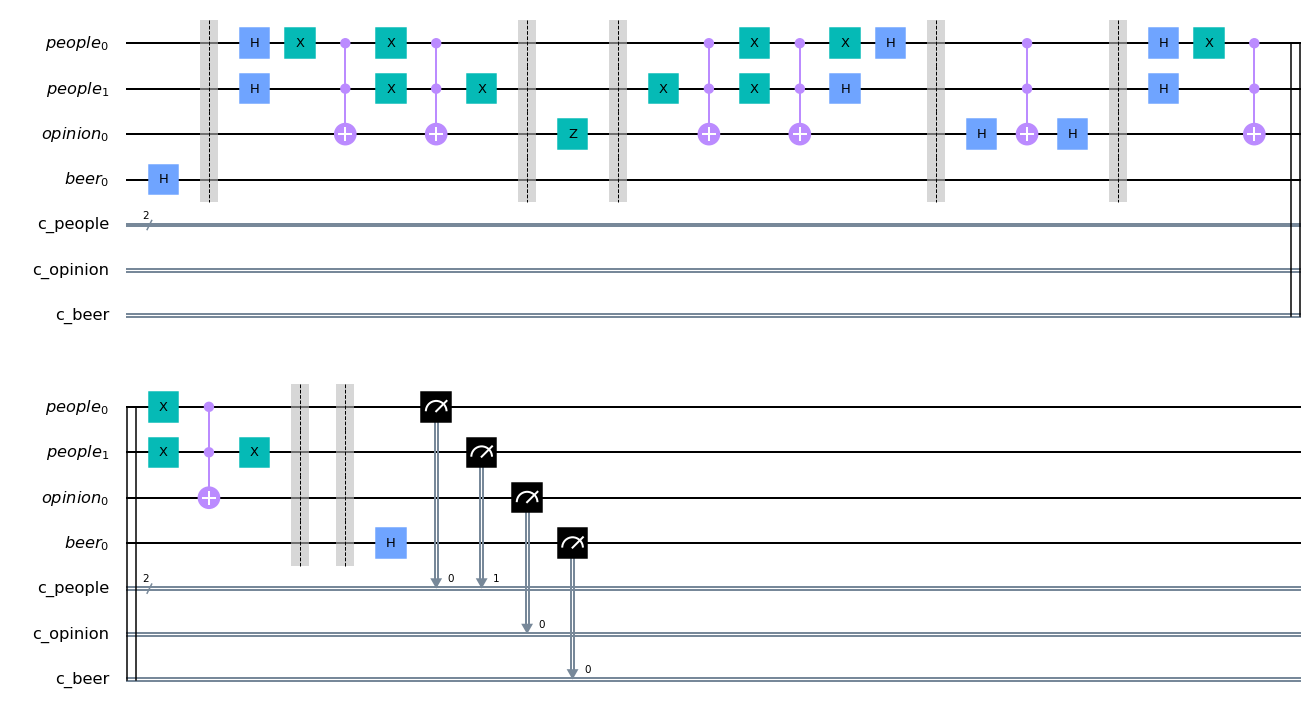

In [33]:
C = create_circuit(2, 1, [0,1,1,0])

C.draw('mpl')

In [23]:
from qiskit import execute, Aer, IBMQ
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel

provider = IBMQ.load_account()
noisy_backend = provider.get_backend('ibmq_16_melbourne')
noise_model = NoiseModel.from_backend(noisy_backend)

/Users/sergiogago/opt/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2020-09-21 16:51:07,322: Credentials are already in use. The existing account in the session will be replaced.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.069163 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.069084 > 1.066667). Truncating to maximum value.


{'0 0 00': 699, '0 0 01': 413, '0 0 10': 424, '0 0 11': 594, '0 1 00': 54, '0 1 01': 248, '0 1 10': 259, '0 1 11': 12, '1 0 00': 75, '1 0 01': 35, '1 0 10': 46, '1 0 11': 71, '1 1 00': 5, '1 1 01': 35, '1 1 10': 28, '1 1 11': 2}


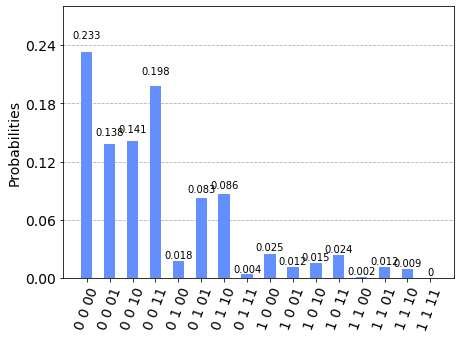

In [43]:
simulator = Aer.get_backend('qasm_simulator') 
shots = 3000
job = execute(C, simulator, shots=shots, noise_model=noise_model)
result = job.result()
counts = result.get_counts(C)
print(counts); # print the results of the runs
plot_histogram(counts) # Visualise the results

In [52]:
for c in counts:
    result = c.split()
    if(result[1] == '1' and counts[c] / shots > 0.05):
        print(parresult[2], " you are awesome! You are invited")
    if(result[0] == '1' and counts[c] / shots > 0.02):
        print(result[2]," And you also have a beer!")

01  you are awesome! You are invited
10  you are awesome! You are invited
00  And you also have a beer!
11  And you also have a beer!
